In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import catboost as cb
from statistics import mode
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import shap

from utils import *

## Setup the dataframes for feature engineering:

In [2]:
# import dataframes and preprocess them (check file `utils.py` for more details)
churn_data, orders_data = import_and_preprocess()

___
## Set cut-off date:

Churn prediction is aimed towards the future.

It *measures* the chance of a given customer churn in a given date (usually the present, *aka*, **today**).

Since this data is from the past, there has to be a cut-off date to represent the *today from the past*.

I will **chronologically** split the `churn_data` dataframe in 50-25-25% (train-validation-test) and then check if it is a reasonable split, i.e., the proportion of the labels are nearly the same in all df's.

In [3]:
# set indexes to split
first_split = int(churn_data.shape[0] * 0.5)
second_split = first_split + int((churn_data.shape[0] - first_split)/2)

# split df's
churn_train = churn_data.iloc[:first_split]
churn_val = churn_data.iloc[first_split:second_split]
churn_test = churn_data.iloc[second_split:]

In [4]:
# check label proportion in the train, validation and test and dataframes
pd.DataFrame(
    {'train_pct': churn_train.is_churn.value_counts(normalize=True),
    'train_abs': churn_train.is_churn.value_counts(),
    'val_pct': churn_val.is_churn.value_counts(normalize=True),
    'val_abs': churn_val.is_churn.value_counts(),
    'test_pct': churn_test.is_churn.value_counts(normalize=True),
    'test_abs': churn_test.is_churn.value_counts(),
    }
)

,train_pct,train_abs,val_pct,val_abs,test_pct,test_abs
0,0.830049,337,0.980296,199,0.960784,196
1,0.169951,69,0.019704,4,0.039216,8


Looks reasonable. It is better to have a little more churns in the training set, so that the algorithm can better capture its behavior.

Since this type of analysis is time-dependent, one can not simply pick random customers and assign them either to train or validation sets.

Therefore, it would be ideal to better balance the values of churns in both validation and test sets, but unfortunately that is not possible.

In [5]:
# group churners by month
churn_data.set_index('last_purchase_date', drop=True).groupby(pd.Grouper(freq='M')).sum()

,customer_code,is_churn
last_purchase_date,,
2018-01-31,41497,24
2018-02-28,48735,24
2018-03-31,42114,16
2018-04-30,56352,5
2018-05-31,62513,4
2018-06-30,76360,2
2018-07-31,11304,6


Most churners are in the first 3 months. Grabbing only those months would yield less than 50% of the data for training...

The cut-off date is the last date in the training df.

In [6]:
# put the cut-off date in a variable
cutoff = churn_train.last_purchase_date.iloc[-1]

# check it
cutoff

Timestamp('2018-04-24 00:00:00')

The cut-off date (*aka* **today**) is April 24, 2018.

Before proceeding, the `orders_data` df must be adjusted to match the cut-off date. Any info after this date (the future) should be unknown to the model. All statics derived from data should be calculated until this date.

In [7]:
# slice `orders_date` to match the cut-off date
cutoff_orders = orders_data.query("register_date <= @cutoff").copy()   # copy() is just to avoid warnings about setting values into a copy of a slice of a df

The second cut-off date only serves as the day that divides the testing and the validation sets.

In [8]:
# second cut-off date (spoiler alert: this will be ued in the future steps)
churn_val.last_purchase_date.iloc[-1]

Timestamp('2018-06-06 00:00:00')

___
# Customer segmentation (RFM analysis)
RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

RFM analysis ranks each customer on the following factors:

- Recency: How recent was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours;
- Frequency: How often did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers;
- Monetary value: How much money did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.

*Source:* [SearchDataManagement](https://searchdatamanagement.techtarget.com/definition/RFM-analysis)

___
- # Recency

How recent was the customer's last purchase?

In [9]:
cutoff_orders

,customer_code,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code
0,588,6,212,2008-01-04,710.79,0,20,2675,255.90,11.42,0,0
1,588,6,212,2008-01-04,710.79,0,2,1768,166.04,79.07,0,0
2,588,6,212,2008-01-04,710.79,0,20,282,363.08,16.21,0,0
3,114,7,130,2008-01-05,341.65,1,50,2675,382.65,6.83,2,2
4,681,6,45,2008-01-07,705.94,6,10,2630,176.85,16.84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
196640,126,0,83,2018-04-24,4674.95,23831,1,25,14.80,13.86,0,0
196641,239,0,181,2018-04-24,2935.76,23836,1,1767,52.15,52.15,0,0
196642,190,0,5,2018-04-24,1002.07,23843,2,1417,72.23,31.39,0,0
196643,164,6,252,2018-04-24,1855.81,23841,2,2627,96.98,48.49,0,0


In [10]:
# create a df of customer's info: each customer ID has its unique instance
# this df will be populated throughout this notebook and will be used for ML
customers = cutoff_orders.groupby('customer_code', as_index=False).agg(
    group_code=('group_code', mode),
    segment_code=('segment_code', mode),
    seller_code=('seller_code', mode),
    sales_channel=('sales_channel', mode),
    ).astype({'group_code': 'category', 'segment_code': 'category', 'seller_code': 'category', 'sales_channel': 'category'})

In [11]:
# create a column to check the 'real' value of the order, without any discounts (as explained in the previous notebook)
cutoff_orders['item_full_price'] = cutoff_orders['quantity'] * cutoff_orders['unit_price']

# create a df with info from each order, i.e., indexed by `order_id` (but it wasn't set as the index properly said just for simplicity)
grouped_orders = (
    cutoff_orders
    .groupby('order_id', as_index=False)
    .agg(
        customer_code=('customer_code', mode),   # capture the customer id of the order
        register_date=('register_date', mode),   # capture the date of the order
        total_price=('total_price', mode),   # capture the total price paid by the customer (with discounts)
        full_price=('item_full_price', sum)   # sum the 'true' value of all items
    )
)

# create a column with the % of the discount given (actual price paid divided by the full price)
grouped_orders['discount'] = round(1 - grouped_orders['total_price']/grouped_orders['full_price'], 3)

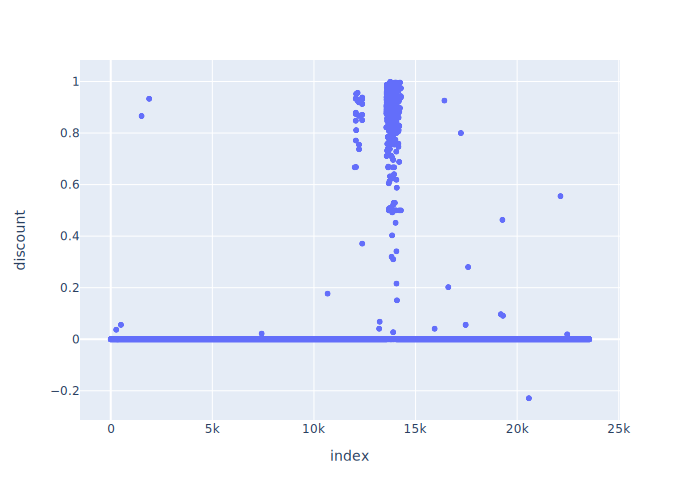

In [12]:
# check the distribution of discounts for all orders
fig = px.scatter(data_frame=grouped_orders, y='discount')
fig.show('svg')

Not every customer gets discounts, but the ones that do are very happy! (> 80% discount)

In [13]:
# get the last purchase date of each customer and add it to `customers`
max_date = (
    grouped_orders
    .groupby('customer_code')
    ['register_date']
    .max()
    .rename('last_purchase')
)
customers = customers.merge(max_date, on='customer_code')

In [14]:
# calculate recency: how many days have passed since the customer's last purchase (from the cut-off date backwards)
customers['recency'] = (cutoff - customers['last_purchase']).dt.days

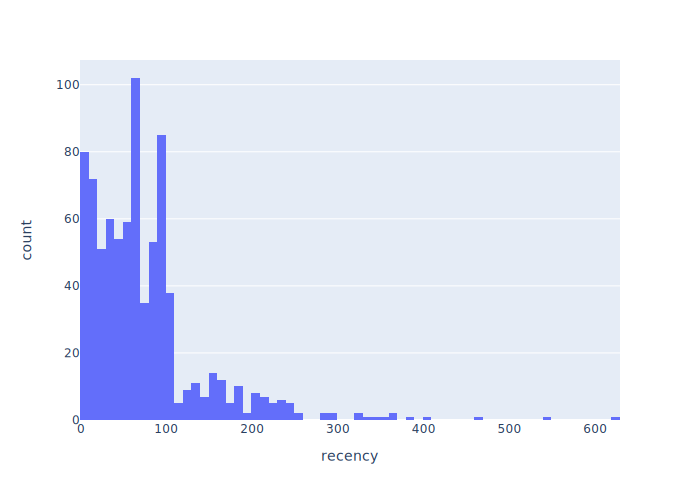

In [15]:
# plot recency
fig = px.histogram(data_frame=customers, x='recency')
fig.show('svg')

___
- # Frequency

How often did this customer make a purchase in a given period?

The steps here are very similar to the ones in the previous section.

In [16]:
# get the frequency of purchases until the cut-off date and add it to `customers`
frequency = (
    grouped_orders
    .groupby('customer_code')
    ['register_date']
    .count()
    .rename('frequency')
)   # creates a Series with the number of purchases per customer

customers = customers.merge(frequency, on='customer_code')

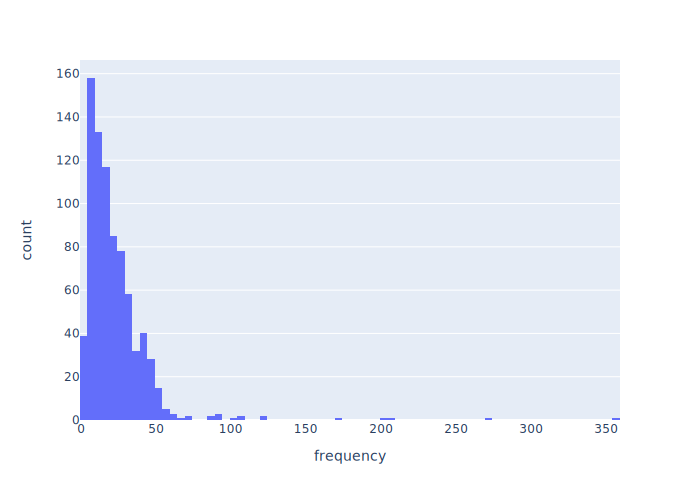

In [17]:
# check frequency distribution (since it varies a lot, I'm capping it at 400)
fig = px.histogram(data_frame=customers.query('frequency < 400'), x='frequency')
fig.show('svg')

___
- # Monetary value

How much money did the customer spend in a given period?

Again: the steps here are very similar to the ones in the previous sections.

In [18]:
# get the monetary value of each customer and add it to `customers`
monetary = (
    grouped_orders
    .groupby('customer_code')
    ['total_price']
    .sum()
    .rename('monetary')
)   # creates a Series with the generated revenue per customer

customers = customers.merge(monetary, on='customer_code')

In [19]:
# visualize how `customers` is looking
customers.head()

,customer_code,group_code,segment_code,seller_code,sales_channel,last_purchase,recency,frequency,monetary
0,0,0,0,153,0,2018-01-24,90,18,70041.37
1,1,0,0,154,1,2018-03-12,43,42,83235.74
2,2,0,0,224,0,2018-02-21,62,38,95480.46
3,3,0,0,134,1,2017-12-23,122,62,364700.95
4,4,0,0,3,1,2018-01-18,96,41,102746.06


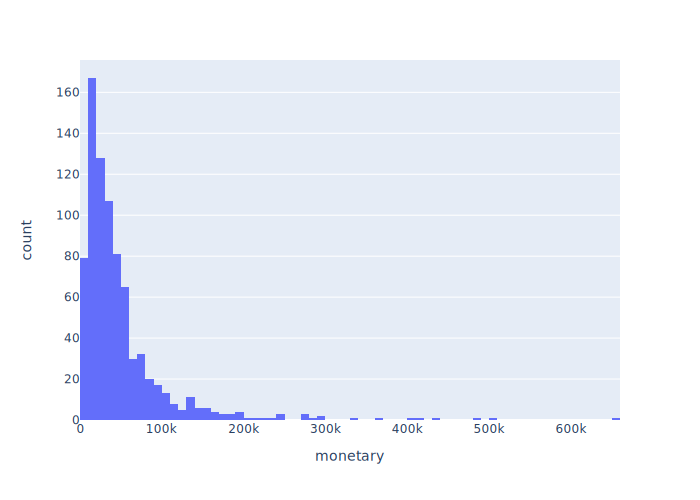

In [20]:
# check monetary values below 1 million
fig = px.histogram(data_frame=customers.query('monetary < 1E6'), x='monetary')
fig.show('svg')

___
## Get the difference of days between the last purchase and the other 3 previous ones

These 3 features try to capture how spaced is each purchase from the last one.

The rationale behind this is that customers with increasing time periods or long periods between purchases might be prone to churn.

In [21]:
# get the day of purchase of all orders for all customers
last_3_purchases = (
    grouped_orders
    [['customer_code', 'register_date']]
    .sort_values(['customer_code', 'register_date'])   # sort by date
    .drop_duplicates()   # if more than one purchase is made in a single day, this deletes all entries but one
)

In [22]:
# shift the purchase date 3 times, so that later we can just subtract each one from the last purchase
last_3_purchases['register_date_1'] = last_3_purchases.groupby('customer_code')['register_date'].shift(1)
last_3_purchases['register_date_2'] = last_3_purchases.groupby('customer_code')['register_date'].shift(2)
last_3_purchases['register_date_3'] = last_3_purchases.groupby('customer_code')['register_date'].shift(3)

In [23]:
# get the number of days passed from the 1st, 2nd and 3rd orders before the last one
last_3_purchases['day_diff_1'] = (last_3_purchases['register_date'] - last_3_purchases['register_date_1']).dt.days
last_3_purchases['day_diff_2'] = (last_3_purchases['register_date'] - last_3_purchases['register_date_2']).dt.days
last_3_purchases['day_diff_3'] = (last_3_purchases['register_date'] - last_3_purchases['register_date_3']).dt.days

In [24]:
# get only one entry (the most recent one) for each customer
last_3_purchases = last_3_purchases.drop_duplicates(subset=['customer_code'], keep='last')

### Problem!
If a customer does not have at least 4 purchases, one (or more) of their `day_diff` columns will contain a `NaN`.

In [25]:
# check if there are any NaN's
last_3_purchases.isna().sum()

customer_code       0
register_date       0
register_date_1     2
register_date_2     2
register_date_3    22
day_diff_1          2
day_diff_2          2
day_diff_3         22
dtype: int64

There are two possible approaches for this:

1) Drop all customers that do not meet the at-least-4 criteria (causes data loss);

However, there are two different types of cenarios that might be the reason for not having at least 4 purchases:
* The customer churned long ago;
* The customer just started their relations with the company and there's no sufficient data yet.

2) Fill `NaN`s with a chosen value;
* This approach works well for customers that churned long ago, since it ***penalizes*** them with high values of days since the last purchase (hopefully the model will *learn* that);
* New customers will be unapropriately *penalized*. They will be treated the same way as churners, which might *confuse* the model.

**Proposed solution**:

Since not enough information is available from the data, the chosen approach is to simply drop all customers that do not meet the 4-purchases criteria, i.e., 22 customers will be removed.

In [26]:
#  if a row has a NaN, it means that row does not have all data from the last 4 purchases
last_3_purchases = last_3_purchases.dropna()

___
## Mean of discounts

The last created feature should take into account the mean % of discounts a customer gets. Maybe customers that get more discounts are less prone to churn.

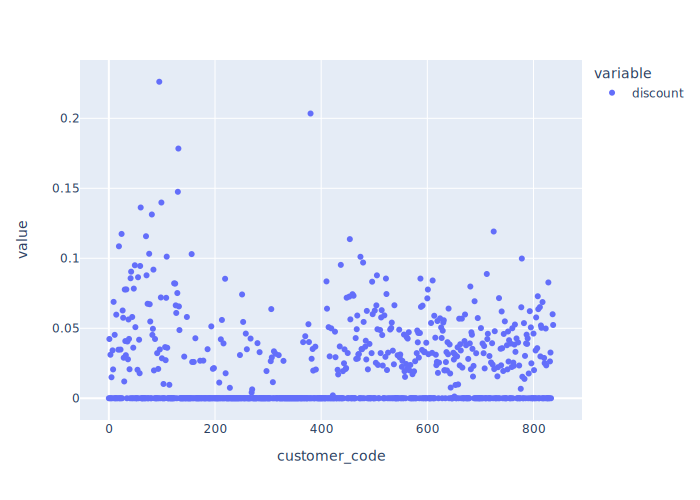

In [27]:
# check the mean of % of discount that each customer gets
discount_by_customer = grouped_orders.groupby('customer_code')['discount'] 
fig = px.scatter(discount_by_customer.mean())
fig.show('svg')

In [28]:
# merge all df's into one
aux_df = last_3_purchases[['customer_code', 'day_diff_1', 'day_diff_2', 'day_diff_3']]

final_df = (
    customers
    .drop(columns='last_purchase')   # already exists on `churn_data`
    .merge(aux_df, on='customer_code')
    .merge(grouped_orders.groupby('customer_code', as_index=False)['discount'].mean(), on='customer_code')
)

In [29]:
# check how it looks
final_df.head()

,customer_code,group_code,segment_code,seller_code,sales_channel,recency,frequency,monetary,day_diff_1,day_diff_2,day_diff_3,discount
0,0,0,0,153,0,90,18,70041.37,166.0,292.0,376.0,0.000000
1,1,0,0,154,1,43,42,83235.74,105.0,235.0,335.0,0.042333
2,2,0,0,224,0,62,38,95480.46,78.0,163.0,321.0,0.000000
3,3,0,0,134,1,122,62,364700.95,129.0,206.0,389.0,0.031081
4,4,0,0,3,1,96,41,102746.06,269.0,462.0,674.0,0.000000


Now, set up train-validation-test sets.

In [30]:
# merge the final df with each split of `churn_data`, keeping only the customers in the respective churn dataframe (train, val, test)
X_train = final_df.merge(churn_train[['customer_code', 'is_churn']], on='customer_code').set_index('customer_code', drop=True)
X_val = final_df.merge(churn_val[['customer_code', 'is_churn']], on='customer_code').set_index('customer_code', drop=True)
X_test = final_df.merge(churn_test[['customer_code', 'is_churn']], on='customer_code').set_index('customer_code', drop=True)

In [31]:
# remove the labels from X's
y_train = X_train.pop('is_churn')
y_val = X_val.pop('is_churn')
y_test = X_test.pop('is_churn')

The features and labels are ready to be used
___

# Model training

Churn prediction should **not** rely entirely on the *accuracy* metric.

It is better to label some non-churners as churners, than label a churner as a non-churner. Avoiding customer churning is imperative!

However, giving too much bonuses/discounts/etc to non-churners wrongly classified as churners leads to money losses.

Thus, an equilibrium metric should be taken. `ROC`, `AUC` and `F-beta score` were chosen to compare the selected models.

`F-beta score` is a weighted version of `F-score`. The `beta` parameter determines the weight of recall in the combined score.

It is estimated that acquiring a new customer is 5 times more expensive than retaining a customer (avoid churning). [source](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/)

Therefore, I shall set `beta = 5`.

### P.S.:
CatBoost has a nice attribute that stores info about feature relevance. I will be using it to remove low-impact features and then retrain all models (steps #1, #2 and #3).

In [32]:
# scale the monetary value
# if you recall from the monetary value analysis, this column has many outliers (which are not really outliers)
# in this case, RobustScaler is a better choice than MinMaxScaler() or 
scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_train_scaled['monetary'] = scaler.fit_transform(X_train[['monetary']])   # fit and transform
X_val_scaled = X_val.copy()
X_val_scaled['monetary'] = scaler.transform(X_val[['monetary']])   # only transform! (to avoid data leakage)
X_test_scaled = X_test.copy()
X_test_scaled['monetary'] = scaler.transform(X_test[['monetary']])   # only transform! (to avoid data leakage)

In [33]:
# create a dic of models to be tested
models = {
        "Logit": LogisticRegression(max_iter=1000),
        "Random_Forest": RandomForestClassifier(),
        "SVC": SVC(),
        "Catboost": cb.CatBoostClassifier(verbose=0, cat_features=['group_code', 'segment_code', 'seller_code', 'sales_channel'])
}

In [34]:
# dic to store metrics
dic_metrics = {}
# fit and score all models
print("----- 1ST TRAINING STEP -----")
print("_____________________________________")
for model_name, model in models.items():
    clf = model
    clf.fit(X_train_scaled, y_train)   
    results = precision_recall_fscore_support(y_val, clf.predict(X_val_scaled), beta=5, labels=[1])
    dic_metrics[model_name] = (
        {
        'accuracy': clf.score(X_val_scaled, y_val),
        'precision_label_1': results[0],
        'recall_label_1': results[1],
        'support_label_1': results[3],
        'f_beta': results[2],
        'AUC': roc_auc_score(y_val, clf.predict(X_val_scaled)),
        'train_step': 1,
        'cm': confusion_matrix(y_val, clf.predict(X_val_scaled)),   # confusion matrix
        'predictions': clf.predict(X_val_scaled)   # will be used to plot the ROC
        }
    )
    if model_name == 'Catboost':   # get feature importances, only available in catboost
        dic_metrics[model_name]['feature_importance'] = clf.feature_importances_
        dic_metrics[model_name]['feature_names'] = clf.feature_names_

    # print results
    print(f"> Model: {model_name}\n")
    print(f"Accuracy: {round(clf.score(X_val_scaled, y_val), 3)}")
    print(f"Recall: {round(results[1][0], 3)}")
    print(f"Precision: {round(results[0][0], 3)}")
    print(f"F-beta score: {round(results[2][0], 3)}")
    print(f"AUC: {round(roc_auc_score(y_val, clf.predict(X_val_scaled)), 3)}")
    print("_____________________________________")    

----- 1ST TRAINING STEP -----
_____________________________________
> Model: Logit

Accuracy: 0.739
Recall: 0.5
Precision: 0.038
F-beta score: 0.34
AUC: 0.622
_____________________________________
> Model: Random_Forest

Accuracy: 0.926
Recall: 0.75
Precision: 0.176
F-beta score: 0.667
AUC: 0.84
_____________________________________
> Model: SVC

Accuracy: 0.98
Recall: 0.75
Precision: 0.5
F-beta score: 0.736
AUC: 0.867
_____________________________________
> Model: Catboost

Accuracy: 0.921
Recall: 0.75
Precision: 0.167
F-beta score: 0.661
AUC: 0.837
_____________________________________


So far SVC has the upper hand: higher `F-beta score` and same `recall` as the other models.

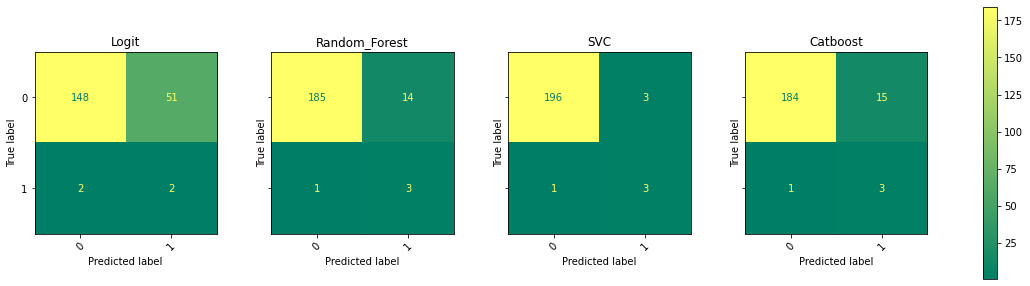

In [35]:
# plot confusion matrix of all models
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, model_name in enumerate(dic_metrics.keys()):
    disp = ConfusionMatrixDisplay(dic_metrics[model_name]['cm'], display_labels=[0, 1])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='summer')
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')

plt.subplots_adjust(wspace=.3, hspace=.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

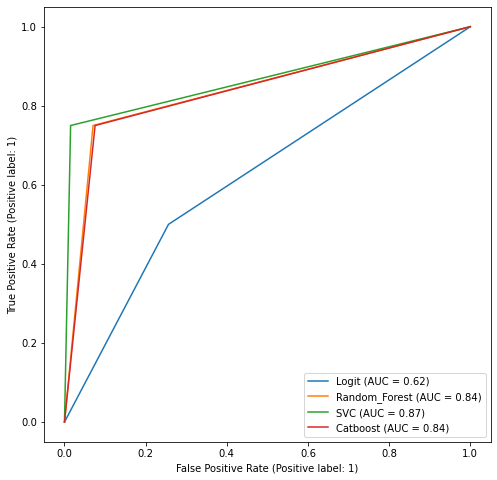

In [36]:
# plot ROC curve for all models
f, ax = plt.subplots(figsize=(8, 8))
for i, model_name in enumerate(dic_metrics.keys()):
    RocCurveDisplay.from_predictions(y_val, dic_metrics[model_name]['predictions'], name=model_name, ax=ax)

Ok, SVC was the best one.

In [37]:
# create dataframe of results
train_results_df = (
    pd.DataFrame(dic_metrics)
    .T   # transpose
    .drop(['cm', 'feature_importance', 'feature_names', 'predictions'], axis=1)
    .explode(['precision_label_1', 'recall_label_1', 'f_beta', 'support_label_1'])   # remove np.array from results
    .astype('float')   # explode() returns object-type values
    .round(3)
)
train_results_df

,accuracy,precision_label_1,recall_label_1,support_label_1,f_beta,AUC,train_step
Logit,0.739,0.038,0.50,4.0,0.340,0.622,1.0
Random_Forest,0.926,0.176,0.75,4.0,0.667,0.840,1.0
SVC,0.980,0.500,0.75,4.0,0.736,0.867,1.0
Catboost,0.921,0.167,0.75,4.0,0.661,0.837,1.0


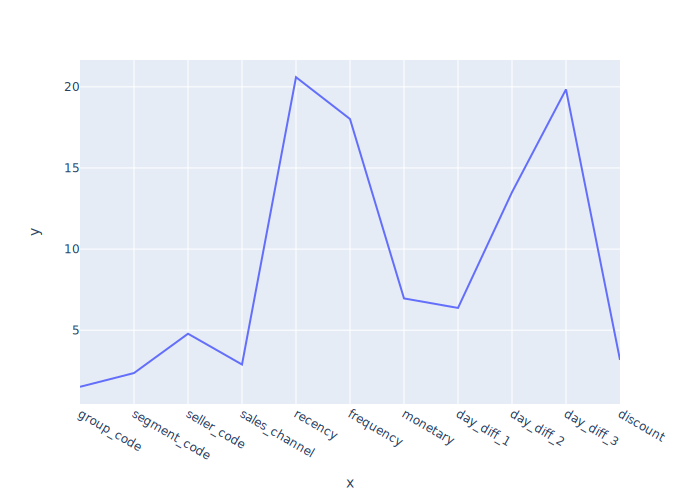

In [38]:
# plot feature relevance from catboost
fig = px.line(y=dic_metrics['Catboost']['feature_importance'], x=dic_metrics['Catboost']['feature_names'])
fig.show('svg')

This suggests that `group_code`, `segment_code`, `seller_code`, `sales_channel` and `discount` have low impact in the model.

I will remove the first four and retrain all models, even though Catboost wasn't the best performing model. This is going to be the 2nd training step.

In [39]:
# create a dic of models to be tested (basically the same dic as `models`, just changing Catboost's instance)
models_2 = {
        "Logit": LogisticRegression(),
        "Random_Forest": RandomForestClassifier(),
        "SVC": SVC(),
        "Catboost": cb.CatBoostClassifier(verbose=0)
}

In [40]:
# remove columns `group_code` and `segment_code`
X_train_scaled_2 = X_train_scaled.drop(columns=['group_code', 'segment_code', 'seller_code', 'sales_channel'])
X_val_scaled_2 = X_val_scaled.drop(columns=['group_code', 'segment_code', 'seller_code', 'sales_channel'])

In [41]:
# dic to store metrics
dic_metrics_2 = {}
# fit and score all models
print("----- 2ND TRAINING STEP -----")
print("_____________________________________")
for model_name, model in models_2.items():
    clf = model
    clf.fit(X_train_scaled_2, y_train)   
    results = precision_recall_fscore_support(y_val, clf.predict(X_val_scaled_2), beta=5, labels=[1])
    dic_metrics_2[model_name] = (
        {
        'accuracy': clf.score(X_val_scaled_2, y_val),
        'precision_label_1': results[0],
        'recall_label_1': results[1],
        'support_label_1': results[3],
        'f_beta': results[2],
        'AUC': roc_auc_score(y_val, clf.predict(X_val_scaled_2)),
        'train_step': 2,
        'cm': confusion_matrix(y_val, clf.predict(X_val_scaled_2)),
        'predictions': clf.predict(X_val_scaled_2)
        }
    )
    if model_name == 'Catboost':   # get feature importances, only available in catboost
        dic_metrics_2[model_name]['feature_importance'] = clf.feature_importances_
        dic_metrics_2[model_name]['feature_names'] = clf.feature_names_

    # print results
    print(f"> Model: {model_name}\n")
    print(f"Accuracy: {round(clf.score(X_val_scaled_2, y_val), 3)}")
    print(f"Recall: {round(results[1][0], 3)}")
    print(f"Precision: {round(results[0][0], 3)}")
    print(f"F-beta score: {round(results[2][0], 3)}")
    print(f"AUC: {round(roc_auc_score(y_val, clf.predict(X_val_scaled_2)), 3)}")
    print("_____________________________________")    

----- 2ND TRAINING STEP -----
_____________________________________
> Model: Logit

Accuracy: 0.729
Recall: 0.5
Precision: 0.036
F-beta score: 0.335
AUC: 0.617
_____________________________________
> Model: Random_Forest

Accuracy: 0.916
Recall: 0.75
Precision: 0.158
F-beta score: 0.655
AUC: 0.835
_____________________________________
> Model: SVC

Accuracy: 0.956
Recall: 0.75
Precision: 0.273
F-beta score: 0.703
AUC: 0.855
_____________________________________
> Model: Catboost

Accuracy: 0.911
Recall: 0.75
Precision: 0.15
F-beta score: 0.65
AUC: 0.832
_____________________________________


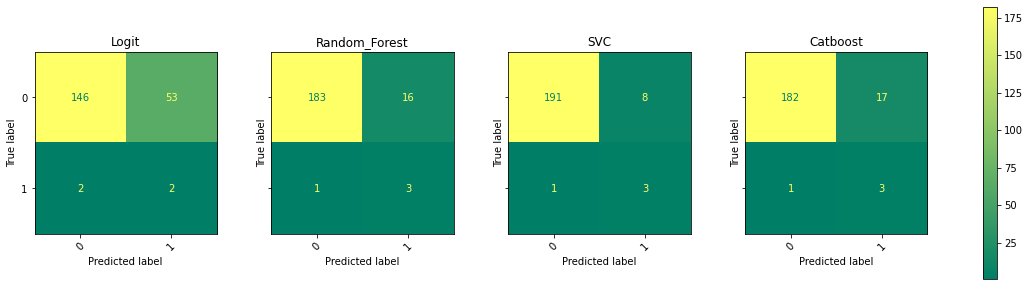

In [42]:
# plot confusion matrix of all models
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, model_name in enumerate(dic_metrics_2.keys()):
    disp = ConfusionMatrixDisplay(dic_metrics_2[model_name]['cm'], display_labels=[0, 1])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='summer')
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')

plt.subplots_adjust(wspace=.3, hspace=.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

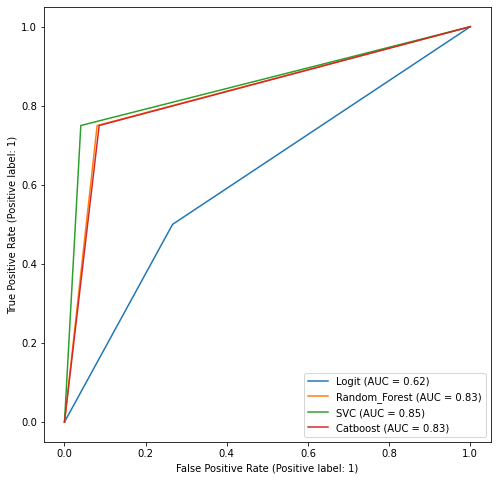

In [43]:
# plot ROC curve for all models
f, ax = plt.subplots(figsize=(8, 8))
for i, model_name in enumerate(dic_metrics_2.keys()):
    RocCurveDisplay.from_predictions(y_val, dic_metrics_2[model_name]['predictions'], name=model_name, ax=ax)

Once again, SVC is the award-winning model.

In [44]:
# merge dataframe of results from this step with the previous one
train_results_df = (
    train_results_df
    .append(
            pd.DataFrame(dic_metrics_2)
            .T   # transpose
            .drop(['cm', 'feature_importance', 'feature_names', 'predictions'], axis=1)
            .explode(['precision_label_1', 'recall_label_1', 'f_beta', 'support_label_1'])   # remove np.array from results
            .astype('float')   # explode() returns object-type values
            .round(3)
    )
)

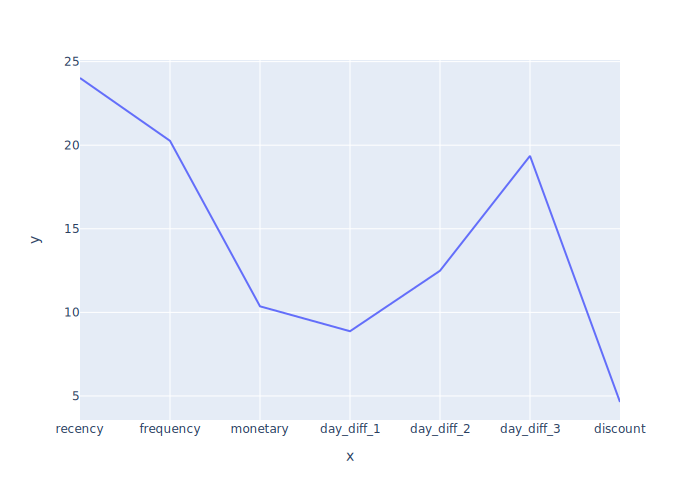

In [45]:
# plot feature relevance from catboost
fig = px.line(y=dic_metrics_2['Catboost']['feature_importance'], x=dic_metrics_2['Catboost']['feature_names'])
fig.show('svg')

`discount` still has low impact.

I will retrain all models one more time, removing `discount` and the other 2 already removed.

In [46]:
# remove columns `group_code` and `segment_code`
X_train_scaled_3 = X_train_scaled.drop(columns=['group_code', 'segment_code', 'seller_code', 'sales_channel', 'discount'])
X_val_scaled_3 = X_val_scaled.drop(columns=['group_code', 'segment_code', 'seller_code', 'sales_channel', 'discount'])

In [47]:
# dic to store metrics
dic_metrics_3 = {}
# fit and score all models
print("----- 3RD TRAINING STEP -----")
print("_____________________________________")
for model_name, model in models_2.items():   # models from the 3rd step are the same from the 2nd one
    clf = model
    clf.fit(X_train_scaled_3, y_train)   
    results = precision_recall_fscore_support(y_val, clf.predict(X_val_scaled_3), beta=5, labels=[1])
    dic_metrics_3[model_name] = (
        {
        'accuracy': clf.score(X_val_scaled_3, y_val),
        'precision_label_1': results[0],
        'recall_label_1': results[1],
        'support_label_1': results[3],
        'f_beta': results[2],
        'AUC': roc_auc_score(y_val, clf.predict(X_val_scaled_3)),
        'train_step': 3,
        'cm': confusion_matrix(y_val, clf.predict(X_val_scaled_3)),
        'predictions': clf.predict(X_val_scaled_3)
        }
    )
    if model_name == 'Catboost':   # get feature importances, only available in catboost
        dic_metrics_3[model_name]['feature_importance'] = clf.feature_importances_
        dic_metrics_3[model_name]['feature_names'] = clf.feature_names_

    # print results
    print(f"> Model: {model_name}\n")
    print(f"Accuracy: {round(clf.score(X_val_scaled_3, y_val), 3)}")
    print(f"Recall: {round(results[1][0], 3)}")
    print(f"Precision: {round(results[0][0], 3)}")
    print(f"F-beta score: {round(results[2][0], 3)}")
    print(f"AUC: {round(roc_auc_score(y_val, clf.predict(X_val_scaled_3)), 3)}")
    print("_____________________________________")    

----- 3RD TRAINING STEP -----
_____________________________________
> Model: Logit

Accuracy: 0.729
Recall: 0.5
Precision: 0.036
F-beta score: 0.335
AUC: 0.617
_____________________________________
> Model: Random_Forest

Accuracy: 0.921
Recall: 0.75
Precision: 0.167
F-beta score: 0.661
AUC: 0.837
_____________________________________
> Model: SVC

Accuracy: 0.946
Recall: 0.75
Precision: 0.231
F-beta score: 0.69
AUC: 0.85
_____________________________________
> Model: Catboost

Accuracy: 0.911
Recall: 0.75
Precision: 0.15
F-beta score: 0.65
AUC: 0.832
_____________________________________


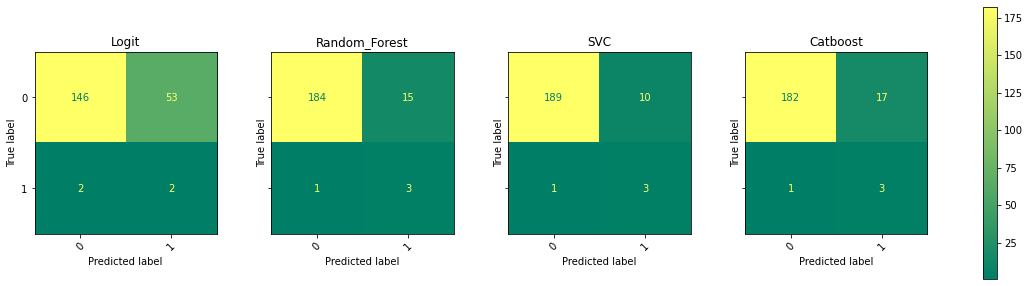

In [48]:
# plot confusion matrix of all models
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, model_name in enumerate(dic_metrics_3.keys()):
    disp = ConfusionMatrixDisplay(dic_metrics_3[model_name]['cm'], display_labels=[0, 1])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='summer')
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')

plt.subplots_adjust(wspace=.3, hspace=.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

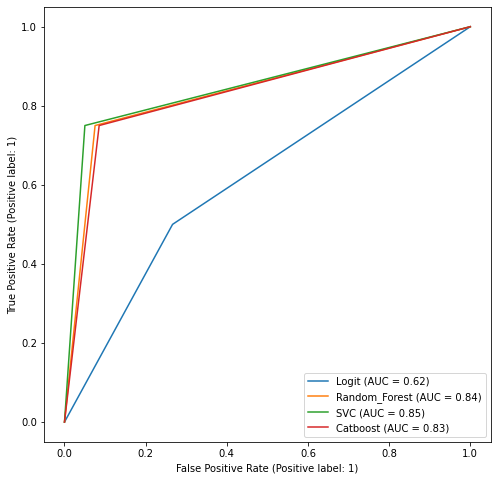

In [49]:
# plot ROC curve for all models
f, ax = plt.subplots(figsize=(8, 8))
for i, model_name in enumerate(dic_metrics_3.keys()):
    RocCurveDisplay.from_predictions(y_val, dic_metrics_3[model_name]['predictions'], name=model_name, ax=ax)

SVC performed the best in all 3 training steps.

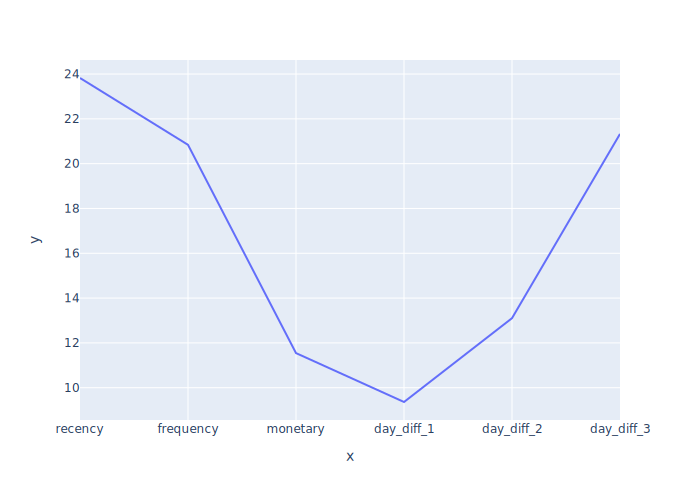

In [50]:
# plot feature relevance from catboost
fig = px.line(y=dic_metrics_3['Catboost']['feature_importance'], x=dic_metrics_3['Catboost']['feature_names'])
fig.show('svg')

Apparently, removing features does not make the models any better...

Checking the results from all steps, remembering that our main metric is `F-beta score`:

In [51]:
# merge dataframe of results from this step with the previous one
train_results_df = (
    train_results_df
    .append(
            pd.DataFrame(dic_metrics_3)
            .T   # transpose
            .drop(['cm', 'feature_importance', 'feature_names', 'predictions'], axis=1)
            .explode(['precision_label_1', 'recall_label_1', 'f_beta', 'support_label_1'])   # remove np.array from results
            .astype('float')   # explode() returns object-type values
            .round(3)
    )
)
train_results_df.sort_values(['f_beta', 'recall_label_1', 'AUC'], ascending=False)

,accuracy,precision_label_1,recall_label_1,support_label_1,f_beta,AUC,train_step
SVC,0.980,0.500,0.75,4.0,0.736,0.867,1.0
SVC,0.956,0.273,0.75,4.0,0.703,0.855,2.0
SVC,0.946,0.231,0.75,4.0,0.690,0.850,3.0
Random_Forest,0.926,0.176,0.75,4.0,0.667,0.840,1.0
Catboost,0.921,0.167,0.75,4.0,0.661,0.837,1.0
Random_Forest,0.921,0.167,0.75,4.0,0.661,0.837,3.0
Random_Forest,0.916,0.158,0.75,4.0,0.655,0.835,2.0
Catboost,0.911,0.150,0.75,4.0,0.650,0.832,2.0
Catboost,0.911,0.150,0.75,4.0,0.650,0.832,3.0
Logit,0.739,0.038,0.50,4.0,0.340,0.622,1.0


___
## Model testing

The best `F-beta score` was from SVC, step #1. It also has the best `AUC` score, and the top results all have a 0.75 recall.

Testing:

In [52]:
print("----- TESTING STEP / SVC #1 -----")
print("_____________________________________")
final = SVC(probability=True)   # same model as SVC in step 1
final.fit(X_train_scaled, y_train)   # same training set as SVC in step 1
results = precision_recall_fscore_support(y_test, final.predict(X_test_scaled), beta=5, labels=[1])
svc_dic = (
    {
    'accuracy': final.score(X_test_scaled, y_test),
    'precision_label_1': results[0],
    'recall_label_1': results[1],
    'support_label_1': results[3],
    'f_beta': results[2],
    'AUC': roc_auc_score(y_test, final.predict(X_test_scaled)),
    'train_step': 1,
    'cm': confusion_matrix(y_test, final.predict(X_test_scaled)),
    'predictions': final.predict(X_test_scaled),
    'probas_pred': final.predict_proba(X_test_scaled)   # will be used to plot recall-precision curve
    }
)
# print results
print(f"> Model: SVC\n")
print(f"Accuracy: {round(final.score(X_test_scaled, y_test), 3)}")
print(f"Recall: {round(results[1][0], 3)}")
print(f"Precision: {round(results[0][0], 3)}")
print(f"F-beta score: {round(results[2][0], 3)}")
print(f"AUC: {round(roc_auc_score(y_test, final.predict(X_test_scaled)), 3)}")  

----- TESTING STEP / SVC #1 -----
_____________________________________
> Model: SVC

Accuracy: 0.891
Recall: 0.5
Precision: 0.136
F-beta score: 0.453
AUC: 0.701


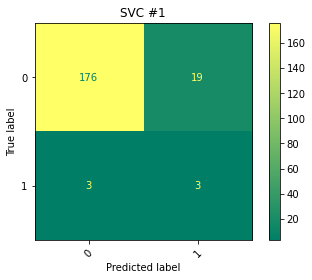

In [53]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(svc_dic['cm'], display_labels=[0, 1])
disp.plot(xticks_rotation=45, cmap='summer')
disp.ax_.set_title('SVC #1')
disp.ax_.set_xlabel('Predicted label')
disp.ax_.set_ylabel('True label')
plt.show()

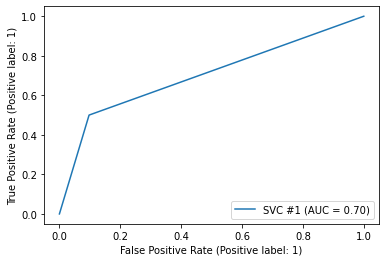

In [54]:
# plot ROC curve 
RocCurveDisplay.from_predictions(y_test, svc_dic['predictions'], name='SVC #1')

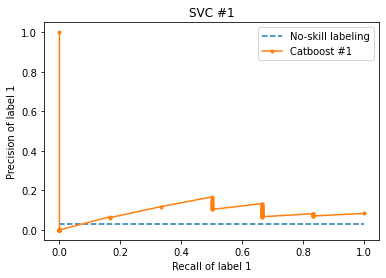

In [55]:
# plot recall-precision curve
prec, rec, _ = precision_recall_curve(y_test, svc_dic['probas_pred'][:, 1])
no_skill = len(y_test[y_test==1]) / len(y_test)   # success rate when all customers are labeled as 1
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No-skill labeling')
plt.plot(rec, prec, marker='.', label='Catboost #1')
plt.xlabel('Recall of label 1')
plt.ylabel('Precision of label 1')
plt.title('SVC #1')
plt.legend()
plt.show()

# TERRIBLE!
Clearly an overfit.

Unfortunately, there is not enough data to perform a better train-val-test technique.

If more data were available, one could, for example, use data from the first 3 months (e.g. Jan., Feb., Mar.), train a model and then validate it on the next 2 months (Apr., May). Then, the time period would move a month forward and a second training would be performed on Feb., Mar., Apr. and use May and Jun. to validate. Next up, Mar., Apr. and May would be trained and then validated on Jun. and Jul. So on so forth. The last `X` months are neither used in train nor in validation, only for testing.

Final parameters of the model would then be selected after a thorough investigation of the results.

___
## Give Catboost another chance

Catboost is a novel library for machine learning, and has increasingly gaining popularity due to its good results.

I will use the test set on it, using the features from the first step (#1).

In [56]:
print("----- TESTING STEP / CATBOOST #1 -----")
print("_____________________________________")
final = cb.CatBoostClassifier(verbose=0, cat_features=['group_code', 'segment_code', 'seller_code', 'sales_channel'])   # same model as CatBoost in step 1
final.fit(X_train_scaled, y_train)   # same training set as CatBoost in step 1  
results = precision_recall_fscore_support(y_test, final.predict(X_test_scaled), beta=5, labels=[1])
catboost_dic = (
    {
    'accuracy': final.score(X_test_scaled, y_test),
    'precision_label_1': results[0],
    'recall_label_1': results[1],
    'support_label_1': results[3],
    'f_beta': results[2],
    'AUC': roc_auc_score(y_test, final.predict(X_test_scaled)),
    'train_step': 1,
    'cm': confusion_matrix(y_test, final.predict(X_test_scaled)),
    'predictions': final.predict(X_test_scaled),
    'probas_pred': final.predict_proba(X_test_scaled)
    }
)
# print results
print(f"> Model: Catboost\n")
print(f"Accuracy: {round(final.score(X_test_scaled, y_test), 3)}")
print(f"Recall: {round(results[1][0], 3)}")
print(f"Precision: {round(results[0][0], 3)}")
print(f"F-beta score: {round(results[2][0], 3)}")
print(f"AUC: {round(roc_auc_score(y_test, final.predict(X_test_scaled)), 3)}") 

----- TESTING STEP / CATBOOST #1 -----
_____________________________________
> Model: Catboost

Accuracy: 0.881
Recall: 0.833
Precision: 0.179
F-beta score: 0.73
AUC: 0.858


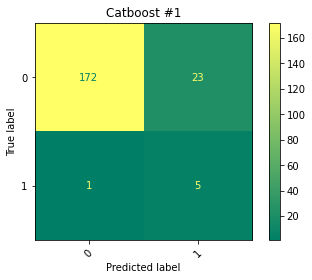

In [57]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(catboost_dic['cm'], display_labels=[0, 1])
disp.plot(xticks_rotation=45, cmap='summer')
disp.ax_.set_title('Catboost #1')
disp.ax_.set_xlabel('Predicted label')
disp.ax_.set_ylabel('True label')
plt.show()

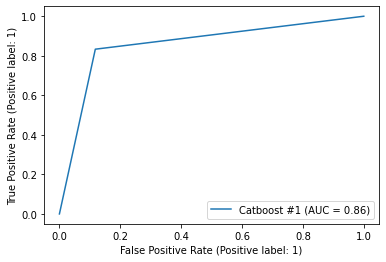

In [58]:
# plot ROC curve 
RocCurveDisplay.from_predictions(y_test, catboost_dic['predictions'], name='Catboost #1')

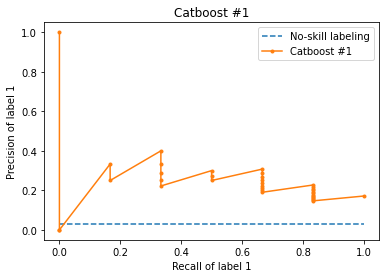

In [59]:
# plot recall-precision curve
prec, rec, _ = precision_recall_curve(y_test, catboost_dic['probas_pred'][:, 1])
no_skill = len(y_test[y_test==1]) / len(y_test)   # success rate when all customers are labeled as 1
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No-skill labeling')
plt.plot(rec, prec, marker='.', label='Catboost #1')
plt.xlabel('Recall of label 1')
plt.ylabel('Precision of label 1')
plt.title('Catboost #1')
plt.legend()
plt.show()

This is less likely to be an overfit. A recall score of 0.833 is pretty decent, meaning that the model is good at detecting true churners.

The precision, however, is terrible, meaning that the model has a high rate of labeling a non-churner as a churner.

If discounts or other monetary benefits are given to every customer labeled as a churner, than many customers that are wrongly labeled as churners would get free discounts (capital loss).

___
## More on feature importance and SHAP values

SHAP is a unified approach to explain the output of any machine learning model. It has a synergistic effect with CatBoost.

Let's see what it has to say, regarding the last fitted model (instantiated in `final`).

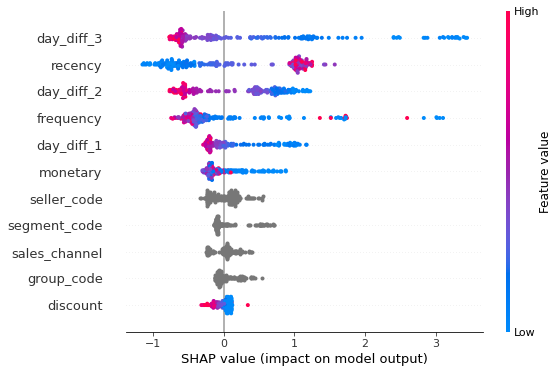

In [60]:
# create a Pool object to store data, as it is mandatory in .get_feature_importance()
pool = cb.Pool(data=X_test_scaled, label=y_test, cat_features=['group_code', 'segment_code', 'seller_code', 'sales_channel'])
# get shap values
shap_values = final.get_feature_importance(data=pool, type='ShapValues')
# remove column of expected values of the model predictions
shap_values = shap_values[:, :-1]
# plot 
shap.summary_plot(shap_values, X_test_scaled)

The above figure gives us some unexpected insights!

- `day_diff_1`, `day_diff_2` and `day_diff_3`: the higher the value of these features, the less likely the customer will churn, which is **unexpected** (and will be better described below, in the `Conclusion` section). Usually, if a lot of days have passed since their latest `n`, `n-1`, `n-2`, etc purchases, it is assumed that the customer is slowly distancing himself/herself away from the company, i.e., more prone to churn;
- `recency`: the higher the value, the more likely it is for a customer to churn. This is expected, since a customer that made a recent purchase (low value of `recency`) is very unlikely to churn right after;
- `frequency`: opposite to `recency`. A customer with high frequency of purchase is less likely to churn;
- `monetary`: same as `frequency`. The higher the monetary value, the less likely it is for the customer to churn;
- `discount`: doesn't affect much the model, but there's a slight decrease in the chance of churning if a customer gets higher discounts;
- `seller_code`, `segment_code`, `sales_channel`, `group_code`: these are unordered categorical features, so there's no such thing as "high" or "low" values.

___
## Conclusion:
1) Churning prediction is, indeed, a very complex topic. The most relevant features that better describe churn prediction are still unknown in the literature;


2) There is a *small* chance that these data depict a **contractual** churn. Like mentioned before, customers with many days since their last purchases are more expected to churn, but this is not the case. *Probably*, these customers are bound by contract and cannot leave the company, while churners with recent purchases made only a no-contract purchase or short-period contract. This could be further investigated by analyzing other features, such as `discount`. Maybe these customers are signing long-term contracts because of higher discounts? Maybe...


3) The next steps would be:
- Model refactoring: once more information on the data is gathered, a refactoring might be needed, either on the type of algorithms used or on feature engineering/selection;
- Try different approaches to tackle the problem: more literature research would be needed for this. One option is to group all orders by month and perform rolling time windows analysis for groups of months (this was already described in this notebook. Quick reminder: use Jan, Feb, Mar as training and Apr as validation. Then Feb, Mar, Apr for training and May for validation, etc, etc, leaving the last 2 or 3 months for final testing). This would act like a **k-fold cross validation** while respecting the chronology of the data, which would improve the parameters of the model, reduce overfitting, etc.;
- Oversampling: this approach has its ups and downs, but it's worth a shot. Usually [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) is used;
- Hyperparameters tuning: optimize the hyperparameters with libraries such as [Optuna](https://optuna.org/);

So far, the developed model has the following project premises:
- Customers not in the dataset of churn data (`churn_data`) were removed from the dataset of orders (`orders_data`);
- Customer with less than 4 purchases were also removed;
- The amount paid by the customer for each order is in `total_price`, even though the sum of all `item_full_price` for an order is equal or lower than the price paid (considered to be discounts);
- `discounts` is the mean of discounts by that customer, even though some customers get no discounts or extremely high discounts.

___
## P.S.:
### This was the next step to be evaluated:

> What if both the train and validation sets are merged, the time period is shifted from the first cut-off date to the second one and all features are recalculated taking into account all the information of orders in the period between cut-offs (from April 24 to June 6)?

> At first glance, this looks like a severe case of data leakage. However, after merging the training and validation sets, the model will not have its parameters recalculated.

> The parameters from the first fit will be kept as is, the analysis date will be shifted (from cut-off date 1 to 2) and all the information unavailable to the original training set (data of orders from April 24 to June 6) will be incorporated into a ***new*** testing set (a new `X_test_scaled`).

> This new testing set will be different from the one used before, since it will have its recency, frequency, monetary value and day differences calculated in respect to June 6, and not April 24.